In [34]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
from typing import List

# №1. Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Levels) в ширину из нескольких заданных стартовых вершин. <br> Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин. <br>  Функция возвращает массив пар: стартовая вершина, и массив (levels), где для каждой вершины указано, на каком уровне она достижима из этой стартовой. Стартовая вершина достижима на нулевом уровне, если вершина не достижима, то значение соответствующей ячейки сделайте равной -1.

In [7]:
# Create initial data objects
edges = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
]
M = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
M

"M_1"      nvals  nrows  ncols  dtype         format
gb.Matrix     12      7      7   BOOL  bitmapr (iso)
----------------------------------------------------
      0     1     2     3     4     5     6
0        True        True                  
1                          True        True
2                                True      
3  True        True                        
4                                True      
5              True                        
6              True  True  True

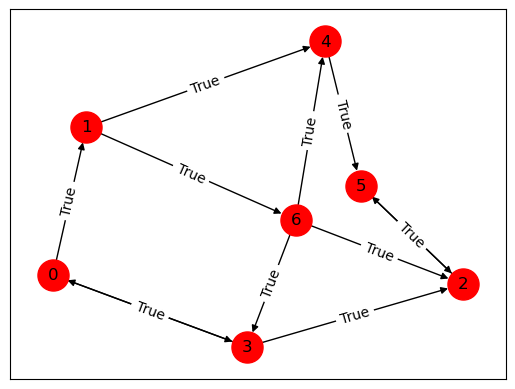

In [11]:
gb.viz.draw(M)

In [83]:
edges = [
    [2, 0, 4, 3, 5, 0, 1, 4, 3, 4, 6, 1],
    [0, 1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6],
]
M2 = Matrix.from_coo(edges[0], edges[1], [True for _ in edges[0]])
M2

"M_938362"  nvals  nrows  ncols  dtype         format
gb.Matrix      12      7      7   BOOL  bitmapr (iso)
-----------------------------------------------------
      0     1     2     3     4     5     6
0        True        True                  
1                    True              True
2  True                                    
3              True        True            
4        True        True        True      
5              True                        
6                                True

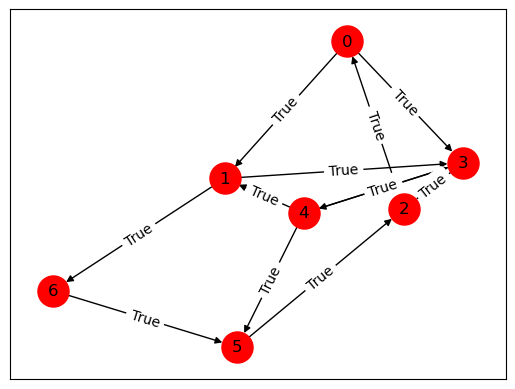

In [92]:
gb.viz.draw(M2)

In [16]:
def msbfs_levels(A: Matrix, start_vertices: List[int]) -> Matrix:
    n = A.nrows
    number_of_start_vertex = len(start_vertices)
    levels = Matrix(dtypes.INT32, number_of_start_vertex, n)  # matrix for result with levels
    f = Matrix(bool, number_of_start_vertex, n)  # frontier
    for ind, val in enumerate(start_vertices):
        f[(ind, val)] << True
    succ = Scalar(bool)
    level = -1  # level in BFS traversal
    while True:
        level += 1
        # For the frontier, assign the depth level
        levels(mask=f.V) << level
        # Compute the next frontier, masking out anything already assigned
        f(~levels.S, replace=True) << f.mxm(A, semiring.lor_land)
        # If next frontier is empty, we're done
        succ << f.reduce_scalar(monoid.lor)
        if not succ:
            break
    return levels

In [17]:
msbfs_levels(M, [1, 3, 5])

"M_6"      nvals  nrows  ncols  dtype   format
gb.Matrix     16      3      7  INT32  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0  3  0  2  2  1  2  1
1  1  2  1  0  3  2  3
2        1        0

In [93]:
msbfs_levels(M2, [1, 3, 5])

"M_938363"  nvals  nrows  ncols  dtype  format
gb.Matrix      21      3      7  INT32   fullr
----------------------------------------------
   0  1  2  3  4  5  6
0  3  0  2  1  2  2  1
1  2  2  1  0  1  2  3
2  2  3  1  3  4  0  4

# №2. Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Parents) в ширину из нескольких заданных стартовых вершин. <br> Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин. <br> Функция возвращает массив пар: стартовая вершина, и массив (parents), где для каждой вершины графа указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины. При этом для самой стартовой вершины такое значение взять равное -1, а для недостижимых вершин взять равное -2. При наличии нескольких возможных значений в массивах parents брать наименьшее.

In [102]:
def msbfs_parents(A: Matrix, start_vertices: List[int]) -> Matrix:
    N = A.nrows
    number_of_start_vertex = len(start_vertices)
    index_ramp = Matrix(dtypes.UINT64, number_of_start_vertex, N)
    index_ramp = index_ramp.from_dense([range(N) for _ in range(number_of_start_vertex)])
    parents = Matrix(dtypes.UINT64, number_of_start_vertex, N)
    for ind, val in enumerate(start_vertices):
        parents[(ind,val)] << val
    wavefront = Matrix(dtypes.UINT64, number_of_start_vertex, N)
    for ind, val in enumerate(start_vertices):
        wavefront[(ind,val)] << 1
    while wavefront.nvals > 0:
        # convert all stored values in wavefront to their 0−based index
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        # ”FIRST” because left−multiplying wavefront rows. Masking out the parent
        # list ensures wavefront values do not overwrite parents already stored.
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
        # Don’t need to mask here since we did it in mxm. Merges new parents in
        # current wave front with existing parents : parents += wavefront
        parents(binary.plus) << wavefront
    return parents

In [103]:
msbfs_parents(M, [1, 3, 5])

"M_938381"  nvals  nrows  ncols   dtype   format
gb.Matrix      16      3      7  UINT64  bitmapr
------------------------------------------------
   0  1  2  3  4  5  6
0  3  1  6  6  1  4  1
1  3  0  3  3  1  2  1
2        5        5

In [104]:
msbfs_parents(M2, [1, 3, 5])

"M_938385"  nvals  nrows  ncols   dtype  format
gb.Matrix      21      3      7  UINT64   fullr
-----------------------------------------------
   0  1  2  3  4  5  6
0  2  1  3  1  3  6  1
1  2  4  3  3  3  4  1
2  2  0  5  0  3  5  1

# №2* Добавить тесты для проверки корректности полученных реализаций.

Сделано выше, на примере из практики

# №3.(+2 балла) Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин.

# №4. (+3 балла) Добавить реализации описанных алгоритмов с использованием других полуколец (any.pair для levels и any.first для parents). Добавить тесты для проверки корректности. Провести экспериментальное исследование со сравнением этих реализаций с первоначальными на различных графах.

In [22]:
def msbfs_levels_any_pair(A: Matrix, start_vertices: List[int]) -> Matrix:
    n = A.nrows
    number_of_start_vertex = len(start_vertices)
    levels = Matrix(dtypes.INT32, number_of_start_vertex, n)  # matrix for result with levels
    f = Matrix(bool, number_of_start_vertex, n)  # frontier
    for ind, val in enumerate(start_vertices):
        f[(ind, val)] << True
    succ = Scalar(bool)
    level = -1  # level in BFS traversal
    while True:
        level += 1
        # For the frontier, assign the depth level
        levels(mask=f.V) << level
        # Compute the next frontier, masking out anything already assigned
        f(~levels.S, replace=True) << f.mxm(A, semiring.any_pair)
        # If next frontier is empty, we're done
        succ << f.reduce_scalar(monoid.lor)
        if not succ:
            break
    return levels

In [23]:
msbfs_levels_any_pair(M, [1, 3, 5])

"M_16"     nvals  nrows  ncols  dtype   format
gb.Matrix     16      3      7  INT32  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0  3  0  2  2  1  2  1
1  1  2  1  0  3  2  3
2        1        0

In [95]:
msbfs_levels_any_pair(M2, [1, 3, 5])

"M_938369"  nvals  nrows  ncols  dtype  format
gb.Matrix      21      3      7  INT32   fullr
----------------------------------------------
   0  1  2  3  4  5  6
0  3  0  2  1  2  2  1
1  2  2  1  0  1  2  3
2  2  3  1  3  4  0  4

In [106]:
def msbfs_parents_any_first(A: Matrix, start_vertices: List[int]) -> Matrix:
    N = A.nrows
    number_of_start_vertex = len(start_vertices)
    index_ramp = Matrix(dtypes.UINT64, number_of_start_vertex, N)
    index_ramp = index_ramp.from_dense([range(N) for _ in range(number_of_start_vertex)])
    parents = Matrix(dtypes.UINT64, number_of_start_vertex, N)
    for ind, val in enumerate(start_vertices):
        parents[(ind,val)] << val
    wavefront = Matrix(dtypes.UINT64, number_of_start_vertex, N)
    for ind, val in enumerate(start_vertices):
        wavefront[(ind,val)] << 1
    while wavefront.nvals > 0:
        # convert all stored values in wavefront to their 0−based index
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        # ”FIRST” because left−multiplying wavefront rows. Masking out the parent
        # list ensures wavefront values do not overwrite parents already stored.
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.any_first)
        # Don’t need to mask here since we did it in mxm. Merges new parents in
        # current wave front with existing parents : parents += wavefront
        parents(binary.plus) << wavefront
    return parents

In [107]:
msbfs_parents_any_first(M, [1, 3, 5])

"M_938389"  nvals  nrows  ncols   dtype   format
gb.Matrix      16      3      7  UINT64  bitmapr
------------------------------------------------
   0  1  2  3  4  5  6
0  3  1  6  6  1  4  1
1  3  0  3  3  1  2  1
2        5        5

In [108]:
msbfs_parents_any_first(M2, [1, 3, 5])

"M_938393"  nvals  nrows  ncols   dtype  format
gb.Matrix      21      3      7  UINT64   fullr
-----------------------------------------------
   0  1  2  3  4  5  6
0  2  1  3  1  3  6  1
1  2  4  3  3  3  4  1
2  2  0  5  0  3  5  1

In [109]:
def test(A: Matrix, print_flag, n_vetices=20):
    s = np.random.randint(0, A.ncols, n_vetices)
    result = [msbfs_levels(A, s), msbfs_parents(A, s), msbfs_levels_any_pair(A, s), msbfs_parents_any_first(A, s)]
    if print_flag:
        for ind, algo_name in enumerate(['msbfs_levels:', 'msbfs_parents:', 'msbfs_levels_any_pair:', 'msbfs_parents_any_first:']):
            print(algo_name, result[ind], end='; ')
    print('msbfs_levels:')
    %timeit msbfs_levels(A, s)
    
    print('msbfs_parents:')
    %timeit msbfs_parents(A, s)
    
    print('msbfs_levels_any_pair:')
    %timeit msbfs_levels_any_pair(A, s)
    
    print('msbfs_parents_any_first:')
    %timeit msbfs_parents_any_first(A, s)

In [49]:
def generate_random_graph(n, density):
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if np.random.rand() < density:
                matrix[i-1, j-1] = 1
    np.fill_diagonal(matrix, 0)
    matrix += matrix.T
    matrix = Matrix.from_dense(matrix, missing_value=0.0)
    return matrix

In [50]:
import os
for file in os.listdir('./Графы_ИТМО/матрицы/'):
    if file == '.DS_Store':
        continue
    matrix = mmread(f'./Графы_ИТМО/матрицы/{file}')
    print(f'name: {file}; nvals: {matrix.nvals}, nrows: {matrix.nrows}, ncols: {matrix.ncols}')
    test(matrix, False)
    print()

name: Erdos992.mtx; nvals: 15030, nrows: 6100, ncols: 6100
msbfs_levels:
5.97 ms ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
msbfs_parents:
13.3 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
msbfs_levels_any_pair:
6.14 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
msbfs_parents_any_first:
13.5 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

name: dictionary28.mtx; nvals: 178076, nrows: 52652, ncols: 52652
msbfs_levels:
33.7 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
msbfs_parents:
75.7 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
msbfs_levels_any_pair:
32.7 ms ± 549 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
msbfs_parents_any_first:
88 ms ± 4.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

name: Erdos982.mtx; nvals: 14750, nrows: 5822, ncols: 5822
msbfs_levels:
7.05 ms ± 71.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
msbfs_par

На больших матрицах можно заметить, что реализация с нестандартными полукольцами показывает лучшие результаты, а на малых видим примерно одинаковые результаты

In [72]:
for i in [100, 200, 500, 1000, 10000]:
  print(f'Количество вершин: {i}, плотность: 0.1, количество стартовых вершин: 20')
  random_graph = generate_random_graph(i, 0.1)
  print(f'nvals: {random_graph.nvals}, nrows: {random_graph.nrows}, ncols: {random_graph.ncols}')
  test(random_graph, False)
  print()

Количество вершин: 100, плотность: 0.1, количество стартовых вершин: 20
nvals: 1038, nrows: 100, ncols: 100
msbfs_levels:
599 µs ± 2.69 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_parents:
922 µs ± 2.53 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_levels_any_pair:
454 µs ± 1.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_parents_any_first:
922 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Количество вершин: 200, плотность: 0.1, количество стартовых вершин: 20
nvals: 3946, nrows: 200, ncols: 200
msbfs_levels:
879 µs ± 793 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_parents:
1.35 ms ± 3.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_levels_any_pair:
500 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_parents_any_first:
1.35 ms ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Количество вершин: 500, плотность: 0.1, коли

С ростом количества вершин при той же плотности время работы растет у всех алгоритмов, можно заметить что msbfs_levels двукратно превосходит стандратный вариант реализации на матрицах малой плотности 

In [73]:
for i in [0.005, 0.05, 0.1, 0.5, 0.8]:
  print(f'Количество вершин: 1000, плотность: {i}, количество стартовых вершин: 20')
  random_graph = generate_random_graph(1000, i) 
  print(f'nvals: {random_graph.nvals}, nrows: {random_graph.nrows}, ncols: {random_graph.ncols}')
  test(random_graph, False)
  print()

Количество вершин: 1000, плотность: 0.005, количество стартовых вершин: 20
nvals: 4940, nrows: 1000, ncols: 1000
msbfs_levels:
2.84 ms ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
msbfs_parents:
4.27 ms ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
msbfs_levels_any_pair:
1.88 ms ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_parents_any_first:
4.23 ms ± 9.44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Количество вершин: 1000, плотность: 0.05, количество стартовых вершин: 20
nvals: 49840, nrows: 1000, ncols: 1000
msbfs_levels:
2.58 ms ± 7.53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
msbfs_parents:
3.47 ms ± 7.49 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
msbfs_levels_any_pair:
1.31 ms ± 3.63 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_parents_any_first:
3.47 ms ± 12.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Количество вершин: 1000, плотность: 0.

С ростом плотности видим аналогичные результаты

In [74]:
for i in [1, 10, 20, 50, 100]:
  print(f'Количество вершин: 500, плотность: 0.1, количество стартовых вершин: {i}')
  random_graph = generate_random_graph(500, 0.1) 
  print(f'nvals: {random_graph.nvals}, nrows: {random_graph.nrows}, ncols: {random_graph.ncols}')
  test(random_graph, False, i)
  print()

Количество вершин: 500, плотность: 0.1, количество стартовых вершин: 1
nvals: 25300, nrows: 500, ncols: 500
msbfs_levels:
330 µs ± 872 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_parents:
373 µs ± 790 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_levels_any_pair:
184 µs ± 509 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
msbfs_parents_any_first:
373 µs ± 369 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Количество вершин: 500, плотность: 0.1, количество стартовых вершин: 10
nvals: 25046, nrows: 500, ncols: 500
msbfs_levels:
830 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_parents:
1.42 ms ± 45.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_levels_any_pair:
387 µs ± 184 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
msbfs_parents_any_first:
1.43 ms ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Количество вершин: 500, плотность: 0.1, колич

Да и с ростом количества стартовых вершин тоже. Но на реальных примерах, как мы видели выше, реализации алгоритмов с разными полукольцами, несильно отличаются по скорости 
